In [1]:
import pymolpro as pmp
import numpy as np
import math
import os

In [2]:

maindb=pmp.database.Database()

for xyz in os.listdir('pubchem'): 
    if xyz.endswith('.xyz'):
        f=open(f'/home/stuart/Hydrocarbons/pubchem/{xyz}')
        maindb.add_molecule(name=xyz[:-4], geometry=f.read())

db=pmp.database.run(maindb,method='locali,pipek;ccsd',basis='cc-pVTZ', parallel=1, postamble='put,xml')

In [3]:
def dictbuilder(orbital):
    oid,noid=orbital.ID,f'-{orbital.ID}'
    #build the grid using n points and evaluate
    points=orbital.grid(n)
    values=orbital.evaluate(points,values=True)
    #values=values**2
    #puts them into the dictionaries
    orbitaldt.update({oid:values})
    orbitaldt.update({f'-{oid}':values})
    #probably unnecessary, but works
    if orbital.ID not in griddt:
        griddt[orbital.ID] = {}
        griddt[f'-{orbital.ID}']={}
    #xyz is arbitrary, just to keep consistency and easy to call later
    griddt[oid].update({i:{
        'x':points[i][0],
        'y':points[i][1],
        'z':points[i][2]
        }for i in range(len(points))})
    griddt[f'-{oid}'].update({i:{
        'x':points[i][0],
        'y':points[i][1],
        'z':points[i][2]
        }for i in range(len(points))})

def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False

In [4]:
#settings
#number of grid points to use (will increase input features n**3 and compute time the same way so dont go too high
n=4

#the arrays are stored in a list until the end of the calculations to then be np.stack()
selffeaturelist=[]
selflabellist=[]
noselffeatlist=[]
noselflabellist=[]

for k,v in db.projects.items():
    #used to store the density key = orbital ID, values=orbital.evaluate
    orbitaldt={}
    #stores the XYZ coordinates for the grid to later be used for the distances. key= orbital id, values= 'x','y','z'
    griddt={}
    for orbital in v.orbitals():
        #stores the evaluated orbital and grid coordinates in different dictionaries
        dictbuilder(orbital)
    
    for pair in v.xpath("//pair"):
        temp=pmp.element_to_dict(pair)
        oid1,oid2=temp['orbital1'],temp['orbital2']
        if chkorbid(oid1,oid2)==True:
            selffeaturelist.append(np.array(orbitaldt[oid1]))
            selflabellist.append(float(temp['energy']))
        else:
            continue

selffeatures=np.stack(selffeaturelist)

selflabels=np.stack(selflabellist) 

In [6]:
import tensorflow as tf
import keras

selfdataset=tf.data.Dataset.from_tensor_slices((selffeatures,selflabels))
selfdataset=selfdataset.shuffle(buffer_size=len(selflabellist)).batch(batch_size=1)

inp_shape=(1,n**3)

model=keras.Sequential([
    keras.layers.Input(shape=(64,)),
    keras.layers.Dense(256, activation='softmax'),
    keras.layers.Dense(1)
])
model.compile('Adam',loss='huber')
model.fit(selfdataset,epochs=50)
predictions=[i for i in model.predict(selfdataset)]



Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 846us/step - loss: 1.5180e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - loss: 1.6671e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 9.7514e-07
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 556us/step - loss: 5.8450e-07
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 5.5871e-07
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 4.5913e-07
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 6.0763e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 5.6202e-07
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 8.1585e-07
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 5.1033e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 5.2617e-07
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 7.2525e-07
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step - loss: 9.3519e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 547

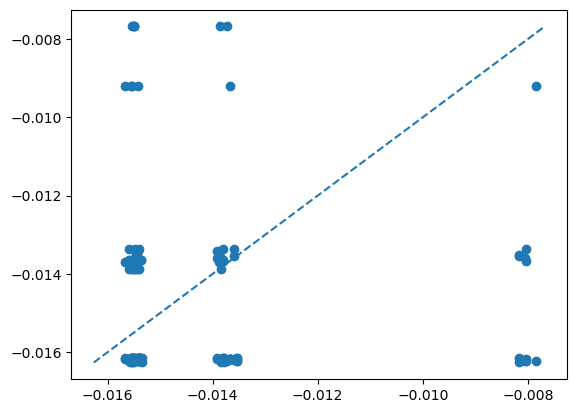

In [7]:
import matplotlib.pyplot as plt

plt.scatter(predictions,selflabellist)
plt.plot((min(selflabellist),max(selflabellist)),(min(selflabellist),max(selflabellist)), linestyle='--')

In [8]:
from sklearn.metrics import mean_squared_error
import gc
def buildmodel(acti,depth):
    model=keras.Sequential()
    model.add(keras.layers.Input(shape=(64,)))
    model.add(keras.layers.Dense(200,activation='softmax'))
    for i in range(depth):
        model.add(keras.layers.Dense(200,activation=acti))
    model.add(keras.layers.Dense(1))
    model.compile('Adam',loss='Huber')
    return model

acti_list=['sigmoid','relu','tanh']
units_list=[i for i in range(64,320,64)]

sig_resultslist=[]
mish_resultslist=[]
relu_resultslist=[]
tanh_resultslist=[]
for depth in range(1,10):
    for acti in acti_list:
        keras.backend.clear_session()
        gc.collect()
        print(model.summary())
        model=buildmodel(acti,depth)
        model.fit(selfdataset,epochs=50)
        predictions=model.predict(selfdataset)
        if acti=='sigmoid':
            sig_resultslist.append(mean_squared_error(selflabellist,predictions))
        elif acti=='relu':
            relu_resultslist.append(mean_squared_error(selflabellist,predictions))
        elif acti=='tanh':
            tanh_resultslist.append(mean_squared_error(selflabellist,predictions))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,693 (198.02 KB)

 Trainable params: 16,897 (66.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,796 (132.02 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - loss: 0.0191
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 4.6585e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 4.9628e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 7.8568e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 2.7724e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 4.3781e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - loss: 6.3784e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 5.0134e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step - loss: 6.2399e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 4.3343e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 3.9446e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 5.5346e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 6.7052e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 69

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,205 (625.80 KB)

 Trainable params: 53,401 (208.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 106,804 (417.21 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - loss: 1.0952e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 4.1262e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 2.3649e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 1.4047e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 558us/step - loss: 2.3796e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 581us/step - loss: 1.3710e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 1.1340e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 563us/step - loss: 1.3420e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 1.0995e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 1.1355e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 553us/step - loss: 1.2874e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 1.2534e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step - loss: 9.7337e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,205 (625.80 KB)

 Trainable params: 53,401 (208.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 106,804 (417.21 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 889us/step - loss: 2.8016e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 5.0434e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - loss: 3.2570e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step - loss: 2.8387e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 3.1608e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 1.2304e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 1.8309e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 1.9726e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - loss: 2.2297e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step - loss: 1.9333e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step - loss: 1.6287e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 564us/step - loss: 9.7608e-07
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - loss: 1.9002e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,205 (625.80 KB)

 Trainable params: 53,401 (208.60 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 106,804 (417.21 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - loss: 0.0055
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - loss: 1.9554e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 3.4964e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - loss: 5.6277e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 4.8272e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 632us/step - loss: 5.7142e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 5.6748e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 1.8613e-04
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 607us/step - loss: 7.9015e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 1.2481e-04
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 1.2513e-04
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step - loss: 6.2065e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 7.6758e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 65

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,805 (1.07 MB)

 Trainable params: 93,601 (365.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 187,204 (731.27 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - loss: 1.3811e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 3.9735e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 3.1792e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 3.7259e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - loss: 3.6580e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 5.3353e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 3.2632e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 4.1560e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 2.9707e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 2.7091e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 2.9477e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - loss: 2.6351e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 3.1873e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,805 (1.07 MB)

 Trainable params: 93,601 (365.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 187,204 (731.27 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 953us/step - loss: 5.4267e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - loss: 5.1536e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 3.4615e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 3.8728e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - loss: 5.3468e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 4.2569e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 679us/step - loss: 2.9148e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - loss: 1.0323e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 1.4684e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - loss: 1.8465e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 1.7923e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 1.4809e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 1.2653e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 280,805 (1.07 MB)

 Trainable params: 93,601 (365.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 187,204 (731.27 KB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0431
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 7.3211e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 1.6563e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - loss: 1.1343e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 9.9886e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 1.3683e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - loss: 1.2393e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 2.4900e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 2.2331e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 2.0803e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - loss: 4.3534e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - loss: 2.6549e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 3.3675e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 690u

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,405 (1.53 MB)

 Trainable params: 133,801 (522.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 267,604 (1.02 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.0352e-05  
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 6.7507e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - loss: 4.4170e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 4.5719e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2071e-06 
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - loss: 4.3609e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - loss: 3.5644e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 4.6498e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - loss: 3.7860e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - loss: 2.8883e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - loss: 3.6051e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 2.0202e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 3.8582e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,405 (1.53 MB)

 Trainable params: 133,801 (522.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 267,604 (1.02 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2193e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - loss: 4.4607e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step - loss: 4.9109e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 4.4595e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - loss: 5.4171e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - loss: 6.9275e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - loss: 5.1884e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 3.5965e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - loss: 6.0250e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - loss: 4.8492e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 715us/step - loss: 4.6338e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - loss: 2.5086e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 1.5803e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 401,405 (1.53 MB)

 Trainable params: 133,801 (522.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 267,604 (1.02 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0761
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - loss: 5.7646e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - loss: 7.4470e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - loss: 6.3247e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - loss: 7.1698e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - loss: 9.0754e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 1.9987e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5518e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 1.3690e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - loss: 1.6046e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - loss: 1.6955e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - loss: 1.9311e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 2.0106e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,005 (1.99 MB)

 Trainable params: 174,001 (679.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 348,004 (1.33 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3463e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - loss: 7.4090e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 3.7068e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - loss: 5.4968e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - loss: 6.5729e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 4.0431e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 2.7806e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.1755e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - loss: 3.2270e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 4.3115e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 2.7582e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - loss: 1.9380e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - loss: 4.9405e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 82

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,005 (1.99 MB)

 Trainable params: 174,001 (679.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 348,004 (1.33 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.0333e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - loss: 3.9633e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 4.7871e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - loss: 3.9369e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - loss: 5.5432e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - loss: 6.0540e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7227e-06  
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3183e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 3.6178e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 3.8038e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - loss: 2.1512e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - loss: 1.5800e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 5.2067e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 522,005 (1.99 MB)

 Trainable params: 174,001 (679.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 348,004 (1.33 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0174
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 1.0436e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - loss: 2.1561e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - loss: 1.9879e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - loss: 2.3616e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 1.2613e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - loss: 4.4116e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 2.4712e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 3.2902e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8663e-05 
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7913e-05 
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - loss: 5.9618e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 4.7584e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,605 (2.45 MB)

 Trainable params: 214,201 (836.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 428,404 (1.63 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0719e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - loss: 3.9492e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - loss: 4.1317e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5159e-06 
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - loss: 2.4082e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 2.3956e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.8758e-06  
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1141e-06 
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1434e-06  
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - loss: 3.0984e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 3.0588e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - loss: 2.3337e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 3.6492e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,605 (2.45 MB)

 Trainable params: 214,201 (836.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 428,404 (1.63 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.2849e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 6.8653e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - loss: 4.1028e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - loss: 6.2861e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 5.6038e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8961e-06 
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - loss: 7.6686e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 4.0213e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - loss: 6.5156e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step - loss: 7.0289e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - loss: 6.5562e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 3.4432e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 2.8936e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 8

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 642,605 (2.45 MB)

 Trainable params: 214,201 (836.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 428,404 (1.63 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0125
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - loss: 1.2132e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - loss: 3.7722e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 2.5329e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 1.8695e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - loss: 2.8674e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - loss: 3.4388e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - loss: 4.6829e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - loss: 3.9460e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2186e-05 
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9597e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 6.5845e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 7.9425e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 763,205 (2.91 MB)

 Trainable params: 254,401 (993.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 508,804 (1.94 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.0991e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1453e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 5.3719e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 3.6202e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6334e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.3269e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - loss: 2.8222e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0798e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - loss: 3.8602e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - loss: 4.3496e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8405e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - loss: 2.9291e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 2.9831e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 763,205 (2.91 MB)

 Trainable params: 254,401 (993.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 508,804 (1.94 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 3.2642e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8538e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7681e-06 
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 7.5533e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - loss: 5.1311e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 3.6349e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 5.3681e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0546e-06  
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - loss: 6.6450e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2087e-06 
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 7.0817e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - loss: 5.2225e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 4.4323e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 763,205 (2.91 MB)

 Trainable params: 254,401 (993.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 508,804 (1.94 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0091
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 1.5203e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - loss: 1.5189e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 4.3235e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6721e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 4.2477e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0393e-05 
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - loss: 5.7071e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6924e-05 
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 3.4860e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3798e-04
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4768e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3789e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,805 (3.37 MB)

 Trainable params: 294,601 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 589,204 (2.25 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3836e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5043e-06  
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9897e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.5220e-06 
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - loss: 4.5725e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7076e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0881e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2895e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6826e-06 
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9401e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2355e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - loss: 2.5192e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - loss: 3.5795e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - l

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,805 (3.37 MB)

 Trainable params: 294,601 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 589,204 (2.25 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 4.7294e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.0919e-06 
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4220e-06 
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7806e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7757e-06  
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 8.1239e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 4.1853e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 6.5173e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - loss: 4.8394e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 3.5091e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - loss: 7.9367e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.0193e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.1700e-06 
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/s

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 883,805 (3.37 MB)

 Trainable params: 294,601 (1.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 589,204 (2.25 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0763
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1785e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1482e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4439e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3919e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3191e-06 
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0260e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3457e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3316e-05 
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2513e-05  
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.2043e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8097e-05  
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 1.7523e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,405 (3.83 MB)

 Trainable params: 334,801 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 669,604 (2.55 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3016e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 3.2391e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 4.7621e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.4207e-06  
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6794e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6815e-06  
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8685e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2111e-06 
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1735e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7460e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.7670e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6536e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8441e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - lo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,405 (3.83 MB)

 Trainable params: 334,801 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 669,604 (2.55 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 5.1072e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - loss: 5.1231e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - loss: 7.7988e-06
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.9586e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 6.5426e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - loss: 4.8113e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.2421e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5450e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8470e-06 
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4147e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 4.8425e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5063e-06  
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - loss: 4.9827e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/ste

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,004,405 (3.83 MB)

 Trainable params: 334,801 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 669,604 (2.55 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0066
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.2004e-05
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2131e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1235e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9067e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1931e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4802e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3143e-04  
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.8701e-05 
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5501e-05 
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1250e-05 
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1634e-04
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.6951e-05
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2074

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,005 (4.29 MB)

 Trainable params: 375,001 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 750,004 (2.86 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.0258e-05
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.9245e-06   
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.5317e-06 
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0590e-06 
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3420e-06 
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1765e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6512e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.0840e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1805e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.6734e-06
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9784e-06 
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0065e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7141e-06  
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        13,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,005 (4.29 MB)

 Trainable params: 375,001 (1.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 750,004 (2.86 MB)

None
Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 8.0472e-04
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7553e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0629e-05 
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3953e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.4749e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.6224e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3371e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.4737e-06
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8311e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1923e-06 
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.7553e-06
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.9609e-06
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.0556e-06
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.098

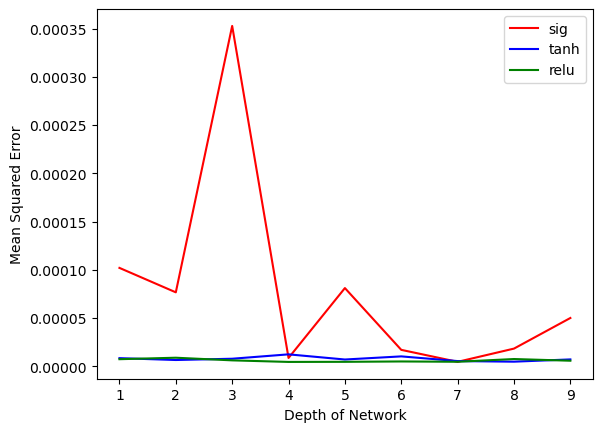

In [9]:
depth_list=[i for i in range(1,10)]
plt.plot(depth_list,sig_resultslist, c='red',label='sig')
plt.plot(depth_list,tanh_resultslist,c='blue',label='tanh')
plt.plot(depth_list,relu_resultslist, c='green',label='relu')

plt.xlabel('Depth of Network')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.savefig('d2depthvmse.png')
plt.show()

In [10]:
model1=keras.Sequential([
    keras.layers.Input(shape=(64,)),
    keras.layers.Dense(200,activation='softmax')
    ])
model2=model1
model3=model1
for i in range(7):
    model1.add(keras.layers.Dense(200,activation='sigmoid'))
    model2.add(keras.layers.Dense(200,activation='relu'))
    model3.add(keras.layers.Dense(200,activation='tanh'))

model1.add(keras.layers.Dense(1))
model2.add(keras.layers.Dense(1))
model3.add(keras.layers.Dense(1))

model1.compile('Adam',loss='huber')
model1.fit(selfdataset,epochs=50)
preds1=model1.predict(selfdataset)

model2.compile('Adam',loss='huber')
model2.fit(selfdataset,epochs=50)
preds2=model2.predict(selfdataset)

model3.compile('Adam',loss='huber')
model3.fit(selfdataset,epochs=50)
preds3=model3.predict(selfdataset)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1036
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.8263e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2181e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0102e-05
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.8598e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0825e-05
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6281e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4714e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6812e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3348e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4422e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0831e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0269e-04
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.7316e-05
Epoch

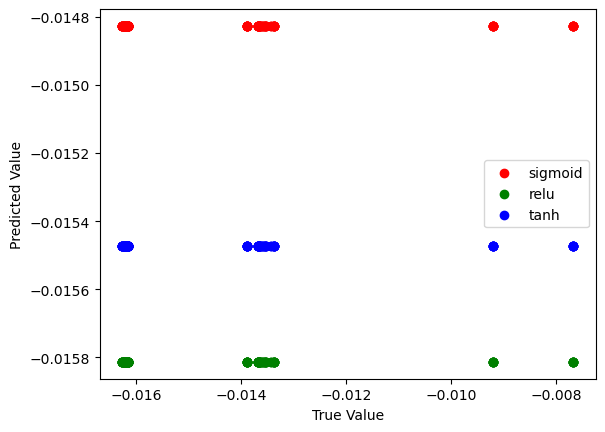

In [11]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.scatter(selflabellist,preds2, c='green',label='relu')
plt.scatter(selflabellist,preds3, c='blue', label='tanh')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.savefig('d27layercomp.png')
plt.show()

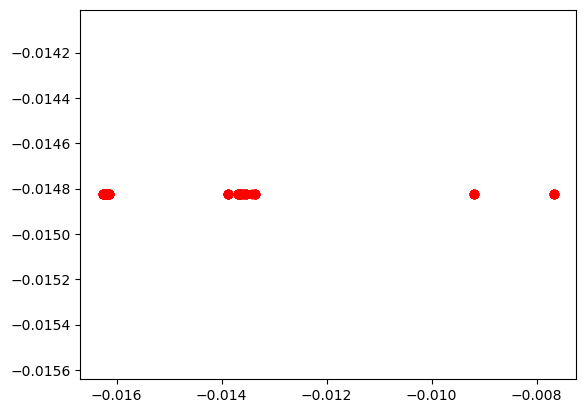

In [12]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.show()

In [13]:
model1=keras.Sequential([
    keras.layers.Input(shape=(64,)),
    keras.layers.Dense(200,activation='softmax')
    ])
model2=model1
model3=model1
for i in range(2):
    model1.add(keras.layers.Dense(200,activation='sigmoid'))
    model2.add(keras.layers.Dense(200,activation='relu'))
    model3.add(keras.layers.Dense(200,activation='tanh'))

model1.add(keras.layers.Dense(1))
model2.add(keras.layers.Dense(1))
model3.add(keras.layers.Dense(1))

model1.compile('Adam',loss='huber')
model1.fit(selfdataset,epochs=50)
preds1=model1.predict(selfdataset)

model2.compile('Adam',loss='huber')
model2.fit(selfdataset,epochs=50)
preds2=model2.predict(selfdataset)

model3.compile('Adam',loss='huber')
model3.fit(selfdataset,epochs=50)
preds3=model3.predict(selfdataset)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0099 
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 4.0143e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6772e-06  
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3122e-06 
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1376e-06
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.4011e-06
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.8551e-06
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5284e-05
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 5.7567e-06
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4734e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7051e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4742e-05
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4105e-05 
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.1477e

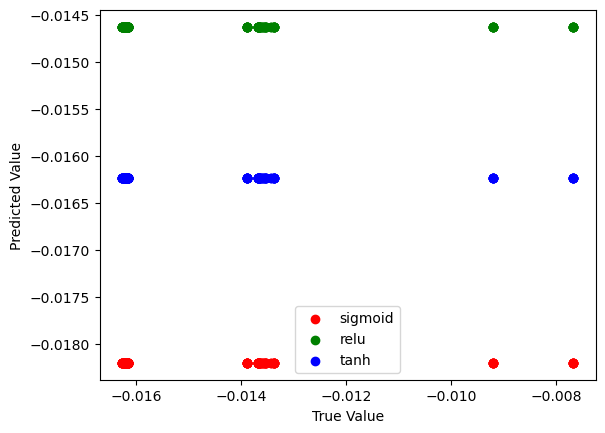

In [14]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.scatter(selflabellist,preds2, c='green',label='relu')
plt.scatter(selflabellist,preds3, c='blue', label='tanh')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.savefig('d22layercomp.png')
plt.show()

In [15]:
model1=keras.Sequential([
    keras.layers.Input(shape=(64,)),
    keras.layers.Dense(200,activation='softmax')
    ])
model2=model1
model3=model1

model1.add(keras.layers.Dense(200,activation='sigmoid'))
model2.add(keras.layers.Dense(200,activation='relu'))
model3.add(keras.layers.Dense(200,activation='tanh'))

model1.add(keras.layers.Dense(1))
model2.add(keras.layers.Dense(1))
model3.add(keras.layers.Dense(1))

model1.compile('Adam',loss='huber')
model1.fit(selfdataset,epochs=50)
preds1=model1.predict(selfdataset)

model2.compile('Adam',loss='huber')
model2.fit(selfdataset,epochs=50)
preds2=model2.predict(selfdataset)

model3.compile('Adam',loss='huber')
model3.fit(selfdataset,epochs=50)
preds3=model3.predict(selfdataset)

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.1068
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - loss: 6.7983e-06
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - loss: 1.0615e-05
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - loss: 8.1766e-06
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - loss: 1.6233e-05
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1977e-05 
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 1.2403e-05
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.3027e-05 
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4486e-05
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - loss: 1.7588e-05
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 1.7881e-05
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0943e-05  
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.0720e-05  
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - lo

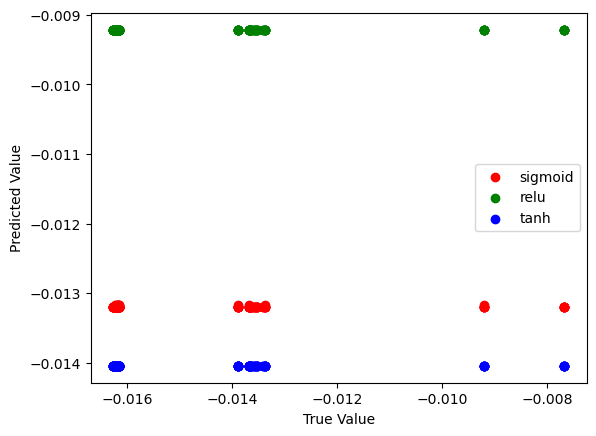

In [16]:
plt.scatter(selflabellist,preds1, c='red',label='sigmoid')
plt.scatter(selflabellist,preds2, c='green',label='relu')
plt.scatter(selflabellist,preds3, c='blue', label='tanh')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.legend()
plt.savefig('d21layercomp.png')
plt.show()

Epoch 1/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 615us/step - loss: 1.4443e-07
Epoch 2/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 4.3779e-07
Epoch 3/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 1.1874e-07
Epoch 4/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - loss: 1.0740e-07
Epoch 5/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 1.3284e-07
Epoch 6/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 546us/step - loss: 1.6950e-07
Epoch 7/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 538us/step - loss: 1.4423e-07
Epoch 8/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 1.1125e-07
Epoch 9/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 4.6059e-07
Epoch 10/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 585us/step - loss: 1.2421e-07
Epoch 11/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 8.2857e-08
Epoch 12/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 7.8555e-08
Epoch 13/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 571us/step - loss: 1.4855e-07
Epoch 14/50
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 569

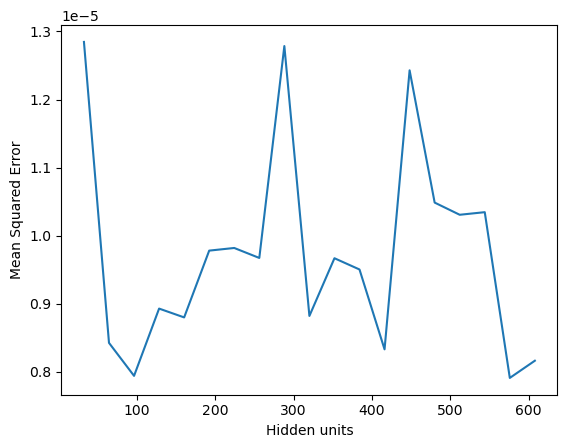

In [9]:
import matplotlib.pyplot as plt
import gc
from sklearn.metrics import mean_squared_error

units_list=[i for i in range(32,640,32)]
def buildmodel(units):
    model=keras.Sequential([
        keras.layers.Input(shape=(64,)),
        keras.layers.Dense(units,activation='softmax'),
        keras.layers.Dense(1)
    ])
    model.compile('Adam',loss='huber')
    return model

mselist=[]
for units in units_list:
    keras.backend.clear_session()
    gc.collect
    buildmodel(units)
    model.fit(selfdataset,epochs=50)
    predictions=model.predict(selfdataset)
    mselist.append(mean_squared_error(selflabellist,predictions))

plt.plot(units_list,mselist)
plt.xlabel('Hidden units')
plt.ylabel('Mean Squared Error')
plt.savefig('UnitsvMSE.png')
plt.show()

In [18]:
model=keras.Sequential([
        keras.layers.Input(shape=(64,)),
        keras.layers.Dense(640,activation='tanh'),
        keras.layers.Dense(1)
    ])
model.compile('Adam',loss='mse')
model.fit(selfdataset,epochs=500)
predictions=model.predict(selfdataset)

Epoch 1/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - loss: 0.0512
Epoch 2/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 2.5077e-04
Epoch 3/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 1.3323e-04
Epoch 4/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - loss: 1.9577e-04
Epoch 5/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 2.9641e-04
Epoch 6/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.0014    
Epoch 7/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 0.0044
Epoch 8/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 6.5930e-04
Epoch 9/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 4.8620e-04
Epoch 10/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - loss: 2.3782e-04
Epoch 11/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 7.0338e-04
Epoch 12/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 592us/step - loss: 1.8353e-04
Epoch 13/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 0s 557us/step - loss: 3.3511e-04
Epoch 14/500
166/166 ━━━━━━━━━━━━━━━━━━━━ 

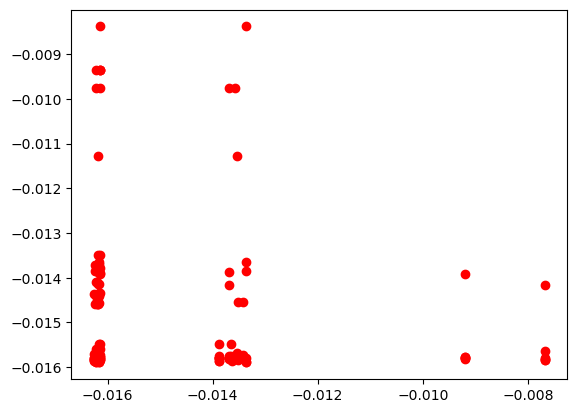

In [19]:
plt.scatter(selflabellist,predictions, c='red')
plt.show()